In [1]:
import os
import ujson as json
import gzip
import pandas as pd

#from urllib.request import urlopen
#import requests
#from bs4 import BeautifulSoup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import base
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import NearestNeighbors
#from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
import scipy.sparse

In [3]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import re

In [4]:
from spacy.lang.en.stop_words import STOP_WORDS
import spacy

import dill 
from functools import reduce

In [5]:
df_merge_new_in = pd.read_csv('data/df_merge_with_URL_1.csv')

In [7]:
df_merge_new_in.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,category,description,title,also_buy,brand,also_view,URL
0,A3RZNH3OPW1XMB,000171287X,CA_Kathy,"[0, 0]",for getting your kid introduced to his/her ABC...,5.0,Great,1375401600,"08 2, 2013","['Books', ""Children's Books"", 'Literature & Fi...","[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...,"['067988632X', '0679887059', '0679886303', 'B0...",Visit Amazon's Stan Berenstain Page,"['0394823249', 'B0015R555M', '0679890483', '06...",https://www.amazon.com/dp/000171287X
1,AZGXZ2UUK6X,000171287X,"Catherine Hallberg ""(Kate)""","[1, 3]","This Book is funny and is full of B words, lik...",3.0,A celebration of B,1061078400,"08 17, 2003","['Books', ""Children's Books"", 'Literature & Fi...","[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...,"['067988632X', '0679887059', '0679886303', 'B0...",Visit Amazon's Stan Berenstain Page,"['0394823249', 'B0015R555M', '0679890483', '06...",https://www.amazon.com/dp/000171287X
2,A2K28JHMIY3XKZ,000171287X,Charles Andrews,"[2, 2]",A favorite Berenstain book of my children I wa...,5.0,Big B Believer,1001894400,"10 1, 2001","['Books', ""Children's Books"", 'Literature & Fi...","[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...,"['067988632X', '0679887059', '0679886303', 'B0...",Visit Amazon's Stan Berenstain Page,"['0394823249', 'B0015R555M', '0679890483', '06...",https://www.amazon.com/dp/000171287X
3,A1Z54EM24Y40LL,000171287X,csm,"[0, 0]",This book is quite funny. Especially when you...,5.0,"Very funny book, sad ending though!",1108080000,"02 11, 2005","['Books', ""Children's Books"", 'Literature & Fi...","[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...,"['067988632X', '0679887059', '0679886303', 'B0...",Visit Amazon's Stan Berenstain Page,"['0394823249', 'B0015R555M', '0679890483', '06...",https://www.amazon.com/dp/000171287X
4,A179R0UL62Q36Z,000171287X,Gena R Kyle,"[0, 0]",Teaching the next generation to love books! M...,5.0,Child's book,1345680000,"08 23, 2012","['Books', ""Children's Books"", 'Literature & Fi...","[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...,"['067988632X', '0679887059', '0679886303', 'B0...",Visit Amazon's Stan Berenstain Page,"['0394823249', 'B0015R555M', '0679890483', '06...",https://www.amazon.com/dp/000171287X


In [102]:
df_merge_new_in["URL"][0]

'https://www.amazon.com/dp/000171287X'

In [103]:
response = requests.get(df_merge_new_in["URL"][0])

In [104]:
soup = BeautifulSoup(response.content, "html.parser")

In [109]:
soup.find("div", {"id":"img-canvas"})

In [98]:
soup.find_all("img")

[<img alt="Amazon.com" id="b" src="https://images-na.ssl-images-amazon.com/images/G/01/error/logo._TTD_.png"/>,
 <img alt="Sorry! Something went wrong on our end. Please go back and try again or go to Amazon's home page." src="https://images-na.ssl-images-amazon.com/images/G/01/error/500_503.png"/>,
 <img alt="Dogs of Amazon" id="d"/>]

In [87]:
import shutil

r = requests.get("https://images-na.ssl-images-amazon.com/images/I/512WMEZXG6L._SX304_BO1,204,203,200_.jpg", stream=True)

if r.status_code == 200:
    with open("image1.jpg", "wb") as f:
        r.raw.decode_content = True
        shutil.copyfileobj(r.raw, f)

In [79]:
html_page = requests.get('http://books.toscrape.com/')
soup = BeautifulSoup(html_page.content, 'html.parser')
warning = soup.find('div', class_="alert alert-warning")
book_container = warning.nextSibling.nextSibling

In [80]:
images = book_container.findAll('img')
example = images[0]
example

<img alt="A Light in the Attic" class="thumbnail" src="media/cache/2c/da/2cdad67c44b002e7ead0cc35693c0e8b.jpg"/>

In [82]:
url_base = "http://books.toscrape.com/" #Original website
url_ext = example.attrs['src'] #The extension you pulled earlier
full_url = url_base + url_ext #Combining first 2 variables to create       a complete URL
r = requests.get(full_url, stream=True) #Get request on full_url
if r.status_code == 200:                     #200 status code = OK
   with open("book1.jpg", 'wb') as f: 
      r.raw.decode_content = True
      shutil.copyfileobj(r.raw, f)

In [85]:
full_url

'http://books.toscrape.com/media/cache/2c/da/2cdad67c44b002e7ead0cc35693c0e8b.jpg'

In [76]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

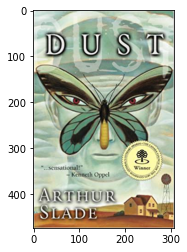

In [88]:
#img = mpimg.imread('book1.jpg')
img = mpimg.imread('image1.jpg')
imgplot = plt.imshow(img)
plt.show()

In [89]:
#
# import pandas as pd
# from IPython.display import Image, HTML
# row_1 = [example.attrs['alt'], '<img src="book1.jpg"/>']
# df = pd.DataFrame(row_1).transpose()
# df.columns = ['Title', 'Cover']
# HTML(df.to_html(escape=False))

,Title,Cover
0,A Light in the Attic,


In [207]:
chunk_size = 5000
chunks = [x for x in range(0, df_merge_new_in.shape[0], chunk_size)]

df_merge_pivot = pd.concat([df_merge_new_in.iloc[ chunks[i]:chunks[i + 1] - 1 ].pivot_table(index='title', columns='reviewerID', values='overall') for i in range(0, len(chunks) - 1)])

In [208]:
df_merge_pivot.fillna(0, inplace=True)

In [209]:
df_merge_matrix = csr_matrix(df_merge_pivot)
df_merge_matrix.todense()
scipy.sparse.save_npz('data/sparse_matrix_with_URL.npz', df_merge_matrix)

In [210]:
#df_merge_matrix = csr_matrix(df_merge_pivot)
sparse_matrix = scipy.sparse.load_npz('data/sparse_matrix_with_URL.npz')
sparse_matrix

<21908x164123 sparse matrix of type '<class 'numpy.float64'>'
	with 394921 stored elements in Compressed Sparse Row format>

In [211]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
#model_knn = NearestNeighbors(metric='cosine', algorithm='ball_tree')
model_knn.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [215]:
distances, indices = model_knn.kneighbors(df_merge_pivot.loc["Harry Potter And The Goblet Of Fire", :].values.reshape(1, -1))

In [350]:
# Recommender from user ratings - collaborative filtering. pivot table + NearestNeighbors
def book_recommender(string):
    
    title = df_merge_pivot[df_merge_pivot.index.str.contains(string)].index[0]
    
    distances, indices = model_knn.kneighbors(df_merge_pivot.loc[title, :].values.reshape(1, -1), n_neighbors=21908)
    titles = df_merge_pivot.index[np.array(indices.flatten())]
    
    return titles, distances.flatten()
    # for i in range(0, len(distances.flatten())):
    #     if i == 0:
    #         print(f'Recommendations for {title}:')
    #     else:
    #         #print('{0}: {1}, with distance of {2}:'.format(i, df_merge_pivot.index[indices.flatten()[i]], distances.flatten()[i]))
    #         print(f"{i}: {df_merge_pivot.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]}")

In [351]:
bambi_rec_collab = book_recommender("Bambi")

In [352]:
bambi_rec_collab

(Index(['Bambi (Disney Classic) (Little Golden Book)',
        'Lady and the Tramp (Disney Lady and the Tramp) (Little Golden Book)',
        'Phineas and Ferb: Runaway Hit',
        'Dumbo (Disney Classic) (Little Golden Book)',
        'Toy Story 3 (Disney/Pixar Toy Story 3) (Little Golden Book)',
        'Monsters University Little Golden Book (Disney/Pixar Monsters University)',
        'Carl Goes Shopping', 'The Pop-Up Mice of Mr. Brice',
        'Spider-Man: Spider-Man versus the Vulture (Spider-Man: I Can Read. Level 2)',
        'Cars 2 Little Golden Book (Disney/Pixar Cars 2)',
        ...
        'The Guys of Twilight (Unauthorized Scrapbook)',
        'The Greedy Triangle (Scholastic Bookshelf)',
        'The Girls' Book: How to Be the Best at Everything',
        'The Girls' Book of Excellence: Even More Ways to Be the Best at Everything',
        'The Girls' Book Of Glamour (Guide To Being A Goddess)',
        'The Giant Diamond Robbery (Geronimo Stilton, No. 44)',
       

In [18]:
df_merge_review_URL = pd.read_csv('data/df_merge_review_title_with_URL.csv')

In [48]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        def to_dict(l):
            try:
                return {x: 1 for x in l}
            except TypeError:
                return {}
        
        return X[self.col].apply(to_dict)

In [49]:
merge_review_pipe = Pipeline([
    ('encoder', DictEncoder('reviewText')),
    ('vectorizer', DictVectorizer())
])
merge_desc_pipe = Pipeline([
    ('encoder', DictEncoder('description')),
    ('vectorizer', DictVectorizer())
])

In [330]:
# Recommender using reviewText and description for each book. vectorizer + FeatureUnion + NearestNeighbors
def book_recommender_text_features(w1, w2, string):
    """
    book recommendation system using
    w1: weight for review feature
    w2: weight for description feature
    string: substring of a title
    """
    union_merge = FeatureUnion([('reviewText', merge_review_pipe),
                      ('description', merge_desc_pipe)],
                    transformer_weights={
            'reviewText': w1,
            'description': w2
        })
    features_merge_review = union_merge.fit_transform(df_merge_review_URL)
    
    union_merge_review_model = NearestNeighbors(metric='cosine', algorithm='brute')
    union_merge_review_model.fit(features_merge_review)
    
    index1 = df_merge_review[df_merge_review.title.str.contains(string)].index[0]
    title1 = df_merge_review[df_merge_review.title.str.contains(string)]['title'].values[0]
    
    #distances, indices = union_merge_review_model.kneighbors(features_merge_review[index1], n_neighbors=6)
    distances, indices = union_merge_review_model.kneighbors(features_merge_review[index1], n_neighbors=df_merge_review_URL.shape[0])
    titles = df_merge_review['title'][df_merge_review.index[np.array(indices.flatten())]].tolist()
    #print(titles)
    
    #return distances, indices, titles
    return titles, distances.flatten()
    # for i in range(0, len(distances.flatten())):
    #     if i == 0:
    #         print(f"Recommendations for {title1}")
    #     else:
    #         print(f"{i}: {df_merge_review['title'][df_merge_review.index[indices.flatten()[i]]]}, with distance of {distances.flatten()[i]}")

In [166]:
df_merge_review[df_merge_review.title.str.contains("Bambi")]

,asin,reviewText,description,overall,title
9647,0736423087,I remember being inconsolable when - as a 5 ye...,"""Beautiful artwork from the 1940s stunningly i...",4.571429,Bambi (Disney Classic) (Little Golden Book)
20168,1616366494,"We love this book, the illustrations, the stor...","'', '', '', '', '', '",5.000000,Bambinelli Sunday: A Christmas Blessing


In [331]:
bambi_rec_vect = book_recommender_text_features(0.2, 1, "Bambi")

In [341]:
def to_dataframe(rec_tuple):
    df = pd.DataFrame(rec_tuple).T
    df.columns = ["title", "distance"]
    return df

In [345]:
to_dataframe(bambi_rec_vect)

,title,distance
0,Bambi (Disney Classic) (Little Golden Book),1.11022e-15
1,The Three Little Pigs (Disney Classic) (Little...,0.0429318
2,Pinocchio (Disney Classic) (Little Golden Book),0.0658934
3,Dumbo (Disney Classic) (Little Golden Book),0.0683234
4,What Really Happened to the Dinosaurs? (DJ and...,0.118022
...,...,...
21946,Big Trucks,0.822898
21947,I Love You Book - I Love You Because You&#39;r...,0.82369
21948,Seby The Dino : Rhyming Images Book For kids -...,0.825624
21949,The Animal Collection - Kindle edition,0.827167


In [353]:
to_dataframe(bambi_rec_collab)

,title,distance
0,Bambi (Disney Classic) (Little Golden Book),1.11022e-16
1,Lady and the Tramp (Disney Lady and the Tramp)...,0.776848
2,Phineas and Ferb: Runaway Hit,0.793311
3,Dumbo (Disney Classic) (Little Golden Book),0.818905
4,Toy Story 3 (Disney/Pixar Toy Story 3) (Little...,0.819813
...,...,...
21903,"The Giant Diamond Robbery (Geronimo Stilton, N...",1
21904,The Ghosts Of Ashbury High,1
21905,The Games Book: How to Play the Games of Yeste...,1
21906,The Gym Teacher from the Black Lagoon,1


In [283]:
def create_list(rec_list):
    list_ = []
    for i in range(len(rec_list[0].flatten())):
        dist_ind = rec_list[0][0][i], rec_list[2][i]
        list_.append(dist_ind)
    return list_

In [270]:
#sorted(create_list(bambi_rec_vect), key=lambda x: x[1])

In [282]:
len(bambi_rec_collab[0].flatten())

21908

In [286]:
#sorted(create_list(bambi_rec_collab), key=lambda x:x[1])

In [162]:
df_merge_review_URL.shape[0]

21951

In [163]:
len(bambi_rec_wv_sort)

21951

In [129]:
list_collab = []
for i in range(21908):
    dist_ind = bambi_rec_collab[0][0][i],  bambi_rec_collab[1][0][i]
    list_collab.append(dist_ind)

In [136]:
# list_vect, list_collab, bambi_rec_wv -> list of (index, ie.distances)

In [141]:
bambi_rec_vect_sort = sorted(list_vect, key=lambda x: x[1])
bambi_rec_collab_sort = sorted(list_collab, key=lambda x:x[1])
bambi_rec_wv_sort = sorted(bambi_rec_wv, key=lambda x:x[0])

In [148]:
metric_tot = [bambi_rec_vect_sort[i][0] + bambi_rec_collab_sort[i][0] + bambi_rec_wv_sort[i][1] for i in range(21908)]

In [158]:
ind_final = np.argsort(metric_tot)[:6]

In [161]:
for i in range(6):
        if i == 0:
            print(f"Recommendations for Bambi")
        else:
            print(f"{i}: {df_merge_review['title'][df_merge_review.index[ind_final.flatten()[i]]]}")

Recommendations for Bambi
1: Bambi (Disney Classic) (Little Golden Book)
2: Child Of Her Heart (Logan's Legacy)
3: Holiday With a Vampire: Christmas Cravings/Fate Calls (Harlequin Nocturne)
4: The Berenstain Bears' New Baby
5: Richard Scarry's Please and Thank You Book (Pictureback(R))


In [ ]:
def combined_model(w_collab, w_vect_desc, w_vect_review, w_feature_union, w_wv, string, n_rec):
    rec_collab = book_recommender(string)
    rec_vect = book_recommender_text_features(w_vect_desc, w_vect_review, string)
    rec_wv = book_recommender_wv(string)
    
    metric = w_collab * rec_collab + w_feature_union * rec_vect + w_wv * rec_wv
    
    ind_f = np.argsort(metric)[:n_rec]
    
    for i in range(n_rec):
        if i == 0:
            print(f"Recommendations for {title}")
        else:
            print(f"{i}: {df_merge_review['title'][df_merge_review.index[ind_final.flatten()[i]]]}")
        
    

In [21]:
#df_merge_review = pd.read_csv('data/df_merge_review_title.csv')

In [37]:
w2v_review_each_book = Word2Vec.load('combined_review_children_books_w2v.model')

def vectorize_combined_reviews(data, maxlen=100, embedding_dim=30):
    """
    Returns a 3D array of shape
    n reviews x maxlen x embedding_dim. 
    """
    # Create empty array
    vectorized_data = np.zeros(shape=(len(data), maxlen, embedding_dim))
    
    for row, review in enumerate(data):
        # Preprocess each review
        tokens = simple_preprocess(review)
        
        # Truncate long reviews
        if len(tokens) > maxlen:
            tokens = tokens[:maxlen]
        
        # Get vector for each token in review
        for col, token in enumerate(tokens):
            try:
                word_vector = w2v_review_each_book.wv[token]
                # Add vector to array
                vectorized_data[row, col] = word_vector[:embedding_dim]
            except KeyError:
                pass
    
    return vectorized_data

maxlen = 100        # Our predetermined limit
embedding_dim = 30 # The first 30 values in our w2v vectors

X = vectorize_combined_reviews(df_merge_review_URL.reviewText, maxlen, embedding_dim)

print('Shape of feature matrix:', X.shape)

Shape of feature matrix: (21951, 100, 30)


In [38]:
# calculate mean of vectors for each book
average_vec = []

for i in range(len(X)):
    average = np.mean(X[i], axis=0)
    average_vec.append(average)

In [409]:
# Recommending the Top 5 similar books

def recommendations_wv(string):
    # finding cosine similarity for the vectors
    cosine_similarities = cosine_similarity(average_vec, average_vec)
    #print(type(cosine_similarities))
    
    #title
    #books = df_merge_review_URL[['title']]
    #print(books)
    #Reverse mapping of the index
    indices = pd.Series(df_merge_review_URL.index, index = df_merge_review_URL['title']).drop_duplicates()
    #print(indices)
    
    title = df_merge_review_URL[df_merge_review_URL.title.str.contains(string) == True].index[0]
    idx = indices[title]
    #print(title, idx) # title == idx?
    # sim_scores = list(enumerate(cosine_similarities[idx]))
    # sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = list(enumerate(1-cosine_similarities[idx]))
    #print(sim_scores)
    ##sim_scores = sorted(sim_scores, key = lambda x: x[1])
    #print(sim_scores)
    titles = df_merge_review_URL['title'][df_merge_review_URL.index[np.array(indices)]].tolist()
    #sim_scores = sim_scores[1:6]
    return titles, sim_scores
#     book_indices = [i[0] for i in sim_scores]
#     recommend = books.iloc[book_indices]
#     #print(recommend, len(recommend))
#     for index, row in recommend.iterrows():
#         print(row['title'], index, row)
        
#     return np.min(cosine_similarities), np.max(cosine_similarities)

In [410]:
bambi_rec_wv = recommendations_wv("Bambi")

In [408]:
#bambi_rec_wv

In [411]:
def to_dataframe(rec_tuple):
    df = pd.DataFrame(rec_tuple).T
    df.columns = ["title", "distance"]
    return df

In [412]:
df_wv = to_dataframe(bambi_rec_wv)

In [413]:
df_wv['distance'] = df_wv['distance'].str[1]

In [414]:
df_wv

,title,distance
0,The Berenstains' B Book (Bright &amp; Early Bo...,0.148870
1,The Berenstain Bears On the Moon (Bright and E...,0.232019
2,On the Edge of Darkness,0.234494
3,Dust,0.207238
4,Shikasta : Re-Colonised Planet 5,0.193065
...,...,...
21946,Knock Knock Jokes (M. Joe King&#39;s Knock Kno...,0.258456
21947,Horribly Ever After eBook,0.222594
21948,Our Beautiful Child eBook,0.281188
21949,Legends of The Vengeance: The First Adventure ...,0.276771


In [ ]:
asin_list = df_merge_review_URL["asin"].tolist()

In [115]:
img_urls = [f"http://images.amazon.com/images/P/{asin}.01._PE30_PI_SCMZZZZZZZ_.jpg" for asin in asin_list]

In [ ]:
for i, asin in enumerate(asin_list):
    response = requests.get(img_urls[i], stream=True)

    if response.status_code == 200:
        with open(f"images/{asin}.jpg", "wb") as f:
            response.raw.decode_content = True
            shutil.copyfileobj(response.raw, f)

In [ ]:
df_merge_review_URL["asin"]

In [ ]:
from IPython.display import Image, HTML

row_1 = [example.attrs['alt'], '<img src="images/book1.jpg"/>']
df = pd.DataFrame(row_1).transpose()
df.columns = ['Title', 'Cover']
HTML(df.to_html(escape=False))

## Data Processing for the Collaborative Filtering

In [6]:
# Dataframe for every review
df_merge_new_in = pd.read_csv('data/df_merge_with_URL_1.csv')

In [7]:
chunk_size = 5000
chunks = [x for x in range(0, df_merge_new_in.shape[0], chunk_size)]

df_merge_pivot = pd.concat([df_merge_new_in.iloc[ chunks[i]:chunks[i + 1] - 1 ].pivot_table(index='title', columns='reviewerID', values='overall') for i in range(0, len(chunks) - 1)])

In [8]:
df_merge_pivot.fillna(0, inplace=True)

In [11]:
import dill
with open("data/df_merge_pivot.dill", "wb") as f:
    dill.dump(df_merge_pivot, f)

OSError: [Errno 28] No space left on device

In [8]:
df_merge_pivot.to_csv("data/df_merge_pivot.csv")

In [12]:
#df_merge_pivot = pd.read_csv("data/df_merge_pivot.csv")

In [27]:
df_merge_matrix = csr_matrix(df_merge_pivot)
df_merge_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
scipy.sparse.save_npz('data/sparse_matrix_with_URL_1.npz', df_merge_matrix)

In [29]:
#df_merge_matrix = csr_matrix(df_merge_pivot)
sparse_matrix = scipy.sparse.load_npz('data/sparse_matrix_with_URL_1.npz')
#sparse_matrix

In [30]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
#model_knn = NearestNeighbors(metric='cosine', algorithm='ball_tree')
model_knn.fit(sparse_matrix)

#distances, indices = model_knn.kneighbors(df_merge_pivot.loc["Harry Potter And The Goblet Of Fire", :].values.reshape(1, -1))

NearestNeighbors(algorithm='brute', metric='cosine')

In [10]:
import dill

In [31]:
with open("data/model_knn_1.dill", "wb") as f:
    dill.dump(model_knn, f)

In [32]:
with open("data/model_knn_1.dill", "rb") as f:
    model_knn = dill.load(f)

In [13]:
model_knn

NearestNeighbors(algorithm='brute', metric='cosine')

## Preprocessing for Vectorizer + FeatureUnion Using Description & ReviewText

In [15]:
# Dataframe sorted for each book/title
df_merge_review_URL = pd.read_csv('data/df_merge_review_title_with_URL_1.csv')

In [39]:
df_merge_review_URL.head(30)

,asin,reviewText,description,overall,title,URL_x,URL_y
0,000171287X,for getting your kid introduced to his/her ABC...,"""In the B Book, the youngest child will be ent...",4.583333,The Berenstains' B Book (Bright &amp; Early Bo...,https://www.amazon.com/dp/000171287X,https://www.amazon.com/dp/000171287X
1,0001714538,This book is so cute and so much fun! We borro...,"'By Stan Berenstain, Illustrated by Stan Beren...",3.714286,The Berenstain Bears On the Moon (Bright and E...,https://www.amazon.com/dp/0001714538,https://www.amazon.com/dp/0001714538
2,0006479286,As I read this book in the wake of rereading T...,"""'STEPHEN KING MEETING WITH RUTH RENDELL' - Fr...",3.888889,On the Edge of Darkness,https://www.amazon.com/dp/0006479286,https://www.amazon.com/dp/0006479286
3,0006485944,I got 80% of the way thru this book and put it...,'Grade 6-9-In a bone-dry summer during the Gre...,4.285714,Dust,https://www.amazon.com/dp/0006485944,https://www.amazon.com/dp/0006485944
4,0006547192,Shikasta is my all-time favorite sci-fi book -...,"""'Magnificent...an astounding book that sets o...",4.200000,Shikasta : Re-Colonised Planet 5,https://www.amazon.com/dp/0006547192,https://www.amazon.com/dp/0006547192
5,0006733271,"I read the first of these back in fifth grade,...",NaN,4.833333,Chronicles of Prydain,https://www.amazon.com/dp/0006733271,https://www.amazon.com/dp/0006733271
6,0006751032,After reading War Horse I wanted to read more ...,'Bertie rescues an orphaned white lion cub fro...,4.800000,The Butterfly Lion,https://www.amazon.com/dp/0006751032,https://www.amazon.com/dp/0006751032
7,0006917801,"I, now 34 years old, like most of the other re...",NaN,4.880000,Alfred Hitchcock and The Three Investigators i...,https://www.amazon.com/dp/0006917801,https://www.amazon.com/dp/0006917801
8,0007111347,While I can see that some readers would be tur...,"""Praise for Laurie R King: 'A compelling, effe...",4.365854,Folly,https://www.amazon.com/dp/0007111347,https://www.amazon.com/dp/0007111347
9,0007111444,I got this book to keep my son entertained in ...,'The pigs are off to the beach for a picnic bu...,5.000000,Cars and Trucks and Things That Go,https://www.amazon.com/dp/0007111444,https://www.amazon.com/dp/0007111444


In [16]:
# Prepare data as a dictionary that can be fed into DictVectorizer
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        def to_dict(l):
            try:
                return {x: 1 for x in l}
            except TypeError:
                return {}
        
        return X[self.col].apply(to_dict)

In [17]:
merge_review_pipe = Pipeline([
    ('encoder', DictEncoder('reviewText')),
    ('vectorizer', DictVectorizer())
])
merge_desc_pipe = Pipeline([
    ('encoder', DictEncoder('description')),
    ('vectorizer', DictVectorizer())
])

## Preprocessing for Word2Vec Model

In [18]:
w2v_review_each_book = Word2Vec.load('combined_review_children_books_w2v_1.model')

def vectorize_combined_reviews(data, maxlen=100, embedding_dim=30):
    """
    Returns a 3D array of shape
    n reviews x maxlen x embedding_dim. 
    """
    # Create empty array
    vectorized_data = np.zeros(shape=(len(data), maxlen, embedding_dim))
    
    for row, review in enumerate(data):
        # Preprocess each review
        tokens = simple_preprocess(review)
        
        # Truncate long reviews
        if len(tokens) > maxlen:
            tokens = tokens[:maxlen]
        
        # Get vector for each token in review
        for col, token in enumerate(tokens):
            try:
                word_vector = w2v_review_each_book.wv[token]
                # Add vector to array
                vectorized_data[row, col] = word_vector[:embedding_dim]
            except KeyError:
                pass
    
    return vectorized_data

maxlen = 100        # Our predetermined limit
embedding_dim = 30 # The first 30 values in our w2v vectors

X = vectorize_combined_reviews(df_merge_review_URL.reviewText, maxlen, embedding_dim)

print('Shape of feature matrix:', X.shape)

Shape of feature matrix: (4233, 100, 30)


In [19]:
# calculate mean of vectors for each book
average_vec = []

for i in range(len(X)):
    average = np.mean(X[i], axis=0)
    average_vec.append(average)

In [20]:
with open("data/average_vec_1.dill", "wb") as f:
    dill.dump(average_vec, f)

### Collection of Recommendation Models

In [41]:
# Recommender from user ratings - collaborative filtering. pivot table + NearestNeighbors
def book_recommender_collab(string):
    
    title = df_merge_pivot[df_merge_pivot.index.str.contains(string)].index[0]
    
    #distances, indices = model_knn.kneighbors(df_merge_pivot.loc[title, :].values.reshape(1, -1), n_neighbors=21908)
    distances, indices = model_knn.kneighbors(df_merge_pivot.loc[title, :].values.reshape(1, -1), n_neighbors=3924)
    titles = df_merge_pivot.index[np.array(indices.flatten())]
    
    return titles, distances.flatten()
    # for i in range(0, len(distances.flatten())):
    #     if i == 0:
    #         print(f'Recommendations for {title}:')
    #     else:
    #         #print('{0}: {1}, with distance of {2}:'.format(i, df_merge_pivot.index[indices.flatten()[i]], distances.flatten()[i]))
    #         print(f"{i}: {df_merge_pivot.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]}")

In [43]:
bambi_rec_collab = book_recommender_collab("The Way")
bambi_rec_collab

(Index(['The Way Back Home', 'Young Cam Jansen and the Speedy Car Mystery',
        'My Secret Camera', 'Adventure Annie Goes to Kindergarten',
        'Little White Rabbit', 'Pat the Cat (Pat the Bunny) (Touch-and-Feel)',
        'Postcards From Puffin: 100 Book Covers in One Box', 'Betsy Red Hoodie',
        'Fairy Wings', 'The Ghost of Nicholas Greebe (Picture Puffins)',
        ...
        'Horrible Harry in Room 2B', 'How Do Apples Grow?',
        'How the Other Half Lives: Studies Among the Tenements of New York',
        'How to Lose All Your Friends (Picture Puffins)', 'Human Development',
        'I Can Read and Speak in Spanish (Book + Audio CD)',
        'I Like Me! (Picture Puffin Books)',
        'IMMIGRANT KIDS (PAPERBACK) 1995C PUFFIN', 'A Fairy Went a-Marketing',
        'Zero Tolerance'],
       dtype='object', name='title', length=3924),
 array([1.11022302e-16, 8.46237528e-01, 8.48881206e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]))

In [23]:
# Recommender using reviewText and description for each book. vectorizer + FeatureUnion + NearestNeighbors
def book_recommender_text_features(w1, w2, string):
    """
    book recommendation system using
    w1: weight for review feature
    w2: weight for description feature
    string: substring of a title
    """
    union_merge = FeatureUnion([('reviewText', merge_review_pipe),
                      ('description', merge_desc_pipe)],
                    transformer_weights={
            'reviewText': w1,
            'description': w2
        })
    features_merge_review = union_merge.fit_transform(df_merge_review_URL)
    
#     with open("data/features_merge_review.dill", "wb") as f:
#         dill.dump(features_merge_review, f)
        
    # with open("data/features_merge_review.dill", "rb") as f:
    #     features_merge_review = dill.load(f)
        
    union_merge_review_model = NearestNeighbors(metric='cosine', algorithm='brute')
    union_merge_review_model.fit(features_merge_review)
    
#     with open("data/union_merge_review_model.dill", "wb") as f:
#         dill.dump(union_merge_review_model, f)
        
    # with open("data/union_merge_review_model.dill", "rb") as f:
    #     union_merge_review_model = dill.load(f)
        
    index1 = df_merge_review_URL[df_merge_review_URL.title.str.contains(string)].index[0]
    title1 = df_merge_review_URL[df_merge_review_URL.title.str.contains(string)]['title'].values[0]
    
    #distances, indices = union_merge_review_model.kneighbors(features_merge_review[index1], n_neighbors=6)
    distances, indices = union_merge_review_model.kneighbors(features_merge_review[index1], n_neighbors=df_merge_review_URL.shape[0])
    titles = df_merge_review_URL['title'][df_merge_review_URL.index[np.array(indices.flatten())]].tolist()
    #print(titles)
    
    #return distances, indices, titles
    return titles, distances.flatten()
    # for i in range(0, len(distances.flatten())):
    #     if i == 0:
    #         print(f"Recommendations for {title1}")
    #     else:
    #         print(f"{i}: {df_merge_review['title'][df_merge_review.index[indices.flatten()[i]]]}, with distance of {distances.flatten()[i]}")

In [46]:
bambi_rec_vect = book_recommender_text_features(0.2, 1, "The Way")
#bambi_rec_vect

In [47]:
# Recommender using Word2Vec model

def book_recommender_wv(string):
    # finding cosine similarity for the vectors
    cosine_similarities = cosine_similarity(average_vec, average_vec)
    
    with open("data/cosine_similarities_1.dill", "wb") as f:
        dill.dump(cosine_similarities, f)
        
    with open("data/cosine_similarities_1.dill", "rb") as f:
        cosine_similarities = dill.load(f)
    
    #print(type(cosine_similarities))
    
    #title
    #books = df_merge_review_URL[['title']]
    #print(books)
    #Reverse mapping of the index
    indices = pd.Series(df_merge_review_URL.index, index = df_merge_review_URL['title']).drop_duplicates()
    #print(indices)
    
    title = df_merge_review_URL[df_merge_review_URL.title.str.contains(string) == True].index[0]
    idx = indices[title]
    #print(title, idx) # title == idx?
    # sim_scores = list(enumerate(cosine_similarities[idx]))
    # sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = list(enumerate(1-cosine_similarities[idx]))
    #print(sim_scores)
    ##sim_scores = sorted(sim_scores, key = lambda x: x[1])
    #print(sim_scores)
    titles = df_merge_review_URL['title'][df_merge_review_URL.index[np.array(indices)]].tolist()
    #sim_scores = sim_scores[1:6]
    return titles, sim_scores
#     book_indices = [i[0] for i in sim_scores]
#     recommend = books.iloc[book_indices]
#     #print(recommend, len(recommend))
#     for index, row in recommend.iterrows():
#         print(row['title'], index, row)
        
#     return np.min(cosine_similarities), np.max(cosine_similarities)

In [48]:
bambi_rec_wv = book_recommender_wv("The Way")

In [50]:
#bambi_rec_wv

In [23]:
def to_dataframe(rec_tuple):
    df = pd.DataFrame(rec_tuple).T
    df.columns = ["title", "distance", "URL", "image"]
    return df

In [29]:
df_wv['distance'] = df_wv['distance'].str[1]

NameError: name 'df_wv' is not defined

## Combined Model

In [24]:
from functools import reduce
import timeit

In [25]:
def combined_model(w_collab=1.0, w_vect_desc=1.0, w_vect_review=0.2, w_feature_union=1.0, w_wv=1.0, string="Bambi", n_rec=5):
    df_collab = to_dataframe(book_recommender_collab(string))
    df_vect = to_dataframe(book_recommender_text_features(w_vect_desc, w_vect_review, string))
    df_wv = to_dataframe(book_recommender_wv(string))
    df_wv['distance'] = df_wv['distance'].str[1]
    
    df_join = reduce(lambda left, right: pd.merge(left,right,on=['title'],
                                            how='outer'), [df_collab, df_vect, df_wv])
    df_join.columns = ['title', 'dist_collab', 'dist_vect', 'dist_wv', 'URL', 'image']
    
    df_join['dist_metric'] = w_collab * df_join['dist_collab'] + w_feature_union * df_join['dist_vect'] \
            + w_wv * df_join['dist_wv']
#     df_join.sort_values('dist_metric')[["title", "dist_metric", "URL", "image"]].head(10)
    
#     # Top 5 book recommendation
#     rec = df_join[['title', 'image_url']].iloc[movie_indices]
       
#     # It reads the top 5 recommend book url and print the images
    
#     for i in rec['image_url']:
#         response = requests.get(i)
#         img = Image.open(BytesIO(response.content))
#         plt.figure()
#         print(plt.imshow(img))
    return df_join.sort_values('dist_metric')[["title", "URL"]].head(n_rec)
    
#     ind_f = np.argsort(metric)[:n_rec]
    
#     for i in range(n_rec):
#         if i == 0:
#             print(f"Recommendations for {title}")
#         else:
#             print(f"{i}: {df_merge_review['title'][df_merge_review.index[ind_final.flatten()[i]]]}")

In [26]:
combined_model(w_collab=1.0, w_vect_desc=1.0, w_vect_review=0.2, w_feature_union=1.0, w_wv=1.0, string="Bambi", n_rec=5)

ValueError: Length mismatch: Expected axis has 2 elements, new values have 4 elements

In [ ]:
# Book indicies
    book_indices = [i[0] for i in sig]
   
    # Top 5 book recommendation
    rec = df_join[['title', 'url']].iloc[book_indices]
       
    # It reads the top 5 recommend book url and print the images
    
    for i in rec['url']:
        response = requests.get(i)
        img = Image.open(BytesIO(response.content))
        plt.figure()
        print(plt.imshow(img))

In [ ]:
print("What is your child's favorite book?")
string = input()

In [16]:
# from bokeh.plotting import figure, show
# from bokeh.layouts import row, column, layout
# from bokeh.models import CustomJS, ColumnDataSource
# from bokeh.models.widgets import Dropdown, CheckboxGroup

# print("What is the most important thing you consider in reading other reviews?")
# LABELS = ["What others users who liked the book chose", 
#           "Similar book descriptions and review contents", 
#           "Similar review contents"]
# first_weight = CheckboxGroup(labels=LABELS, active=[0, 1])
# first_weight.js_on_click(CustomJS(code="""
#     console.log('checkbox_group: active=' + this.active, this.toString())
# """))
# #first_weight.on_change('LABELS', combined_model)
# show(first_weight)
# #show(row(dropdown, checkbox_group))

What is the most important thing you consider in reading other reviews?


In [1]:
# from bokeh.plotting import figure, show
# from bokeh.layouts import row, column, layout
# from bokeh.models import CustomJS, ColumnDataSource
# from bokeh.models.widgets import Dropdown, CheckboxGroup

# menu = sorted(df_merge_review['title'].to_list())
# dropdown = Dropdown(label="Book Titles", button_type="warning", menu=menu)
# #dropdown.js_on_event("menu_item_click", CustomJS(code="console.log('dropdown: ' + this.item, this.toString())"))

# dropdown.on_change('value', combined_model)


# LABELS = ["Collaborative Filtering", "Vectorizer", "Word2Vec"]

# checkbox_group = CheckboxGroup(labels=LABELS, active=[0, 1])
# # checkbox_group.js_on_click(CustomJS(code="""
# #     console.log('checkbox_group: active=' + this.active, this.toString())
# # """))
# checkbox_group.on_change('value', combined_model)

# show(row(dropdown, checkbox_group))

# #combined_model(checkbox_group.feature, dropdown.title)


NameError: name 'df_merge_review' is not defined

In [15]:
from flask import Flask, request

app = Flask(__name__)

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        print(request.form.getlist('hello'))

    return '''<form method="post">
<input type="checkbox" name="hello" value="world" checked>
<input type="checkbox" name="hello" value="davidism" checked>
<input type="submit">
</form>'''

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [04/Mar/2022 13:31:31] "GET / HTTP/1.1" 200 -
